# Introduction to Convolutional Neural Networks (CNNs)

Welcome to this notebook where we will explore Convolutional Neural Networks (CNNs) and their application in image classification. CNNs are a type of deep learning model that have revolutionized the field of computer vision. They are particularly well-suited for tasks involving images and have achieved state-of-the-art results in various domains.

Note, however, that newer architectures are coming out that are even more powerful, one notable recent example being GPT-4o, which does not use CNNs.

## Real-World Applications of CNNs

CNNs have found numerous applications in the real world, including:

1. **Image Classification**: CNNs can classify images into different categories, such as identifying objects, animals, or scenes. This has applications in areas like self-driving cars, medical image analysis, and content moderation.

2. **Object Detection**: CNNs can detect and localize objects within an image, enabling tasks like face detection, pedestrian detection, and autonomous navigation.

3. **Image Segmentation**: CNNs can segment images into different regions or objects, which is useful for applications like medical image segmentation, autonomous driving, and image editing.

4. **Face Recognition**: CNNs are used in face recognition systems to identify individuals based on their facial features. This has applications in security, surveillance, and social media.

5. **Style Transfer**: CNNs can be used to transfer the style of one image to another, allowing the creation of artistic and visually appealing images.

Throughout this notebook, we will dive into the details of CNNs and see how they can be applied to the task of image classification using the CIFAR-10 dataset.

In [19]:
# Install required libraries
# !pip install torch torchvision matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

## Data Preprocessing

Before training our CNN model, we need to preprocess the dataset. The CIFAR-10 dataset consists of 32x32 color images, and we apply the following transformations:

1. **Random Cropping**: We randomly crop the images to a size of 32x32 with padding of 4 pixels on each side. This helps in data augmentation and prevents overfitting.

2. **Random Horizontal Flip**: We randomly flip the images horizontally with a 50% probability. This introduces more variability in the training data.

3. **Conversion to Tensor**: We convert the images from PIL Image format to PyTorch tensors.

4. **Normalization**: We normalize the image tensors by subtracting the mean and dividing by the standard deviation. This helps in faster convergence during training.

In [52]:
# Define transformations for data preprocessing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [53]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## Loading the CIFAR-10 Dataset

We load the CIFAR-10 dataset using the `torchvision.datasets.CIFAR10` class. The dataset is automatically downloaded if it's not already present in the specified directory.

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. The classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

We split the dataset into training and testing sets, applying the respective transformations defined earlier.

In [54]:
# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [56]:
# Define the classes in the CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Visualizing Sample Images

To get a better understanding of the CIFAR-10 dataset, we visualize some random training images along with their corresponding labels.

The `imshow` function is used to display the images. We unnormalize the images by multiplying by 0.5 and adding 0.5 to bring them back to the original pixel range of [0, 1].

In [57]:
# Visualize sample images from the dataset
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [58]:
# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

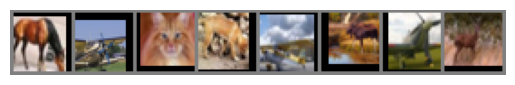

horse plane cat   dog   plane deer  plane deer 


In [59]:
# Show images
imshow(torchvision.utils.make_grid(images[:8]))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

## Defining the CNN Model

We define our CNN model using the `nn.Module` class from PyTorch. The model consists of the following layers:

1. **Convolutional Layer 1**: Applies 32 filters of size 3x3 to the input image. The input has 3 channels (RGB).

2. **Max Pooling Layer**: Performs max pooling with a kernel size of 2x2 and a stride of 2. This reduces the spatial dimensions of the feature maps.

3. **Convolutional Layer 2**: Applies 64 filters of size 3x3 to the output of the previous layer.

4. **Fully Connected Layer 1**: Flattens the output from the convolutional layers and applies a linear transformation to map it to a feature vector of size 128.

5. **Dropout Layer**: Applies dropout regularization with a probability of 0.5 to prevent overfitting.

6. **Fully Connected Layer 2**: Maps the feature vector to the output classes (10 in the case of CIFAR-10).

The `forward` method defines the forward pass of the CNN, specifying how the input is passed through the layers to produce the output.

In [60]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 6 * 6, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 6 * 6)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Model Initialization and Hyperparameters

We initialize an instance of our CNN model using `CNN()`. 

We define the loss function as `nn.CrossEntropyLoss()`, which is commonly used for multi-class classification tasks. It combines the `nn.LogSoftmax()` and `nn.NLLLoss()` functions in a single class.

We choose the Adam optimizer (`optim.Adam`) with a learning rate of 0.001 to optimize the model's parameters. Adam is an adaptive optimization algorithm that automatically adjusts the learning rate based on the gradients.

In [61]:
# Initialize the CNN model
model = CNN()

In [62]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [63]:
# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## Training the Model

We train the CNN model using the following steps:

1. Set the number of epochs and move the model to the available device (GPU if available, otherwise CPU).

2. Iterate over the training data for the specified number of epochs.

3. For each batch of data:
   - Move the inputs and labels to the device.
   - Zero the gradients of the optimizer.
   - Forward pass: Pass the inputs through the model to get the outputs.
   - Calculate the loss between the predicted outputs and the true labels.
   - Backward pass: Compute the gradients of the loss with respect to the model's parameters.
   - Update the model's parameters using the optimizer.

4. Print the training progress every 100 batches, including the current epoch, batch number, and average loss.

5. Repeat steps 3-4 for the specified number of epochs.

After training is finished, the model's parameters will be optimized to minimize the classification loss on the training data.

In [64]:
# Note: If you are using a CPU, the training process will take a while.
# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         inputs, labels = data[0].to(device), data[1].to(device)
        
#         optimizer.zero_grad()
        
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
#         if i % 100 == 99:
#             print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(trainloader)}], Loss: {running_loss/100:.4f}')
#             running_loss = 0.0

# print('Training finished.')

* Epoch [1/10], Batch [100/391], Loss: 1.9968
* Epoch [1/10], Batch [200/391], Loss: 1.7547
* Epoch [1/10], Batch [300/391], Loss: 1.6425
* Epoch [2/10], Batch [100/391], Loss: 1.5692
* Epoch [2/10], Batch [200/391], Loss: 1.5094
* Epoch [2/10], Batch [300/391], Loss: 1.4782
* Epoch [3/10], Batch [100/391], Loss: 1.4325
* Epoch [3/10], Batch [200/391], Loss: 1.3870
* Epoch [3/10], Batch [300/391], Loss: 1.3750
* Epoch [4/10], Batch [100/391], Loss: 1.3238
* Epoch [4/10], Batch [200/391], Loss: 1.2933
* Epoch [4/10], Batch [300/391], Loss: 1.2805
* Epoch [5/10], Batch [100/391], Loss: 1.2499
* Epoch [5/10], Batch [200/391], Loss: 1.2512
* Epoch [5/10], Batch [300/391], Loss: 1.2335
* Epoch [6/10], Batch [100/391], Loss: 1.2120
* Epoch [6/10], Batch [200/391], Loss: 1.2032
* Epoch [6/10], Batch [300/391], Loss: 1.1985
* Epoch [7/10], Batch [100/391], Loss: 1.1714
* Epoch [7/10], Batch [200/391], Loss: 1.1842
* Epoch [7/10], Batch [300/391], Loss: 1.1573
* Epoch [8/10], Batch [100/391], Loss: 1.1369
* Epoch [8/10], Batch [200/391], Loss: 1.1359
* Epoch [8/10], Batch [300/391], Loss: 1.1253
* Epoch [9/10], Batch [100/391], Loss: 1.1098
* Epoch [9/10], Batch [200/391], Loss: 1.1305
* Epoch [9/10], Batch [300/391], Loss: 1.1151
* Epoch [10/10], Batch [100/391], Loss: 1.1108
* Epoch [10/10], Batch [200/391], Loss: 1.1043
* Epoch [10/10], Batch [300/391], Loss: 1.0885
* Training finished.

In [65]:
# Save the trained model
# torch.save(model.state_dict(), 'cnn_model.pth')

In [66]:
model = CNN()
model.load_state_dict(torch.load('cnn_model.pth'))

<All keys matched successfully>

## Evaluating the Model

After training, we evaluate the performance of our CNN model on the test set. We do this by:

1. Setting the model to evaluation mode using `model.eval()`. This is important to disable dropout and use the model for inference.

2. Initializing variables to keep track of the total number of samples and correctly classified samples.

3. Iterating over the test data in batches:
   - Move the images and labels to the device.
   - Forward pass: Pass the images through the model to get the predicted outputs.
   - Get the predicted class labels by taking the argmax of the output probabilities.
   - Update the total number of samples and the number of correctly classified samples.

4. Calculate the accuracy by dividing the number of correctly classified samples by the total number of samples and multiplying by 100.

5. Print the accuracy of the CNN model on the test set.

The accuracy on the test set gives us an estimate of how well our trained CNN model generalizes to unseen data.

In [67]:
# Evaluate the model on the test set
model.eval()
correct = 0
total = 0

In [68]:
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the CNN on the test set: {accuracy:.2f}%')

Accuracy of the CNN on the test set: 10.00%


## Visualizing Learned Filters

To gain insights into what our CNN model has learned, we can visualize the filters (also known as kernels) of the first convolutional layer.

1. Extract the weights of the first convolutional layer (`model.conv1.weight`) and convert them to a NumPy array.

2. Create a grid of subplots with 4 rows and 8 columns to display the filters.

3. Iterate over the filters and plot each filter as a grayscale image in the corresponding subplot.

4. Remove the axis labels and adjust the subplot spacing for better visualization.

5. Display the plot of the learned filters.

Visualizing the learned filters can provide an understanding of the low-level features that the CNN has learned to detect in the input images. These filters often resemble edge detectors, color detectors, or texture patterns.

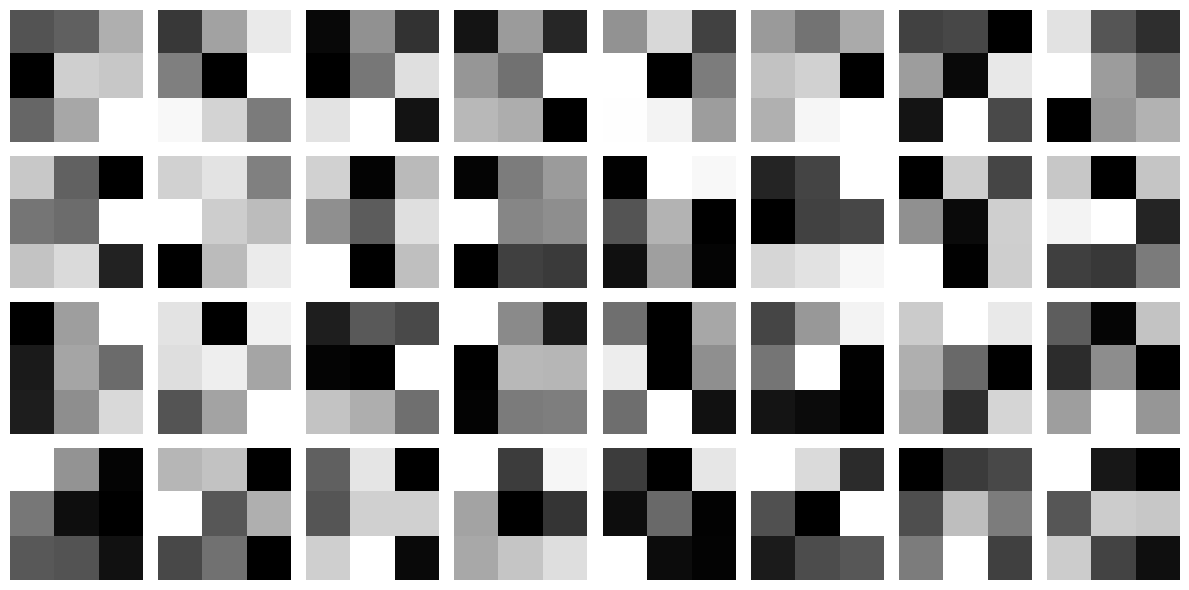

In [70]:
# Visualize learned filters of the first convolutional layer
filters = model.conv1.weight.data.cpu().numpy()
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(filters[i, 0], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Improving the CNN Model

To achieve better accuracy, we can make several improvements to our CNN architecture:

1. Increase the depth of the CNN by adding more convolutional layers.
2. Use larger filter sizes in the convolutional layers to capture more spatial information.
3. Add more fully connected layers to increase the model's capacity.
4. Apply dropout regularization to prevent overfitting.

Here's an example of an improved CNN architecture:

In [71]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 256 * 2 * 2)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [72]:
# Initialize the improved CNN model
improved_model = ImprovedCNN()

In [73]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(improved_model.parameters(), lr=0.001)

## Training the Improved Model

We train the improved CNN model using the same steps as before, but with the new architecture:

In [74]:
# Training loop
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
improved_model.to(device)

ImprovedCNN(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [75]:
# Note: Training the improved model may take a long time
# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         inputs, labels = data[0].to(device), data[1].to(device)
        
#         optimizer.zero_grad()
        
#         outputs = improved_model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
#         if i % 100 == 99:
#             print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(trainloader)}], Loss: {running_loss/100:.4f}')
#             running_loss = 0.0

# print('Training finished.')

* Epoch [1/20], Batch [100/391], Loss: 1.9781
* Epoch [1/20], Batch [200/391], Loss: 1.6831
* Epoch [1/20], Batch [300/391], Loss: 1.5146
* Epoch [2/20], Batch [100/391], Loss: 1.3490
* Epoch [2/20], Batch [200/391], Loss: 1.2926
* Epoch [2/20], Batch [300/391], Loss: 1.2320
* Epoch [3/20], Batch [100/391], Loss: 1.1299
* Epoch [3/20], Batch [200/391], Loss: 1.0927
* Epoch [3/20], Batch [300/391], Loss: 1.0666
* Epoch [4/20], Batch [100/391], Loss: 1.0208
* Epoch [4/20], Batch [200/391], Loss: 0.9946
* Epoch [4/20], Batch [300/391], Loss: 0.9695
* Epoch [5/20], Batch [100/391], Loss: 0.9074
* Epoch [5/20], Batch [200/391], Loss: 0.9009
* Epoch [5/20], Batch [300/391], Loss: 0.8854
* Epoch [6/20], Batch [100/391], Loss: 0.8368
* Epoch [6/20], Batch [200/391], Loss: 0.8427
* Epoch [6/20], Batch [300/391], Loss: 0.8220
* Epoch [7/20], Batch [100/391], Loss: 0.8190
* Epoch [7/20], Batch [200/391], Loss: 0.7899
* Epoch [7/20], Batch [300/391], Loss: 0.7847
* Epoch [8/20], Batch [100/391], Loss: 0.7371
* Epoch [8/20], Batch [200/391], Loss: 0.7562
* Epoch [8/20], Batch [300/391], Loss: 0.7567
* Epoch [9/20], Batch [100/391], Loss: 0.7232
* Epoch [9/20], Batch [200/391], Loss: 0.7243
* Epoch [9/20], Batch [300/391], Loss: 0.7269
* Epoch [10/20], Batch [100/391], Loss: 0.7041
* Epoch [10/20], Batch [200/391], Loss: 0.6784
* Epoch [10/20], Batch [300/391], Loss: 0.6911
* Epoch [11/20], Batch [100/391], Loss: 0.6748
* Epoch [11/20], Batch [200/391], Loss: 0.6780
* Epoch [11/20], Batch [300/391], Loss: 0.6657
* Epoch [12/20], Batch [100/391], Loss: 0.6377
* Epoch [12/20], Batch [200/391], Loss: 0.6521
* Epoch [12/20], Batch [300/391], Loss: 0.6456
* Epoch [13/20], Batch [100/391], Loss: 0.6169
* Epoch [13/20], Batch [200/391], Loss: 0.6294
* Epoch [13/20], Batch [300/391], Loss: 0.6263
* Epoch [14/20], Batch [100/391], Loss: 0.6241
* Epoch [14/20], Batch [200/391], Loss: 0.5962
* Epoch [14/20], Batch [300/391], Loss: 0.6175
* Epoch [15/20], Batch [100/391], Loss: 0.5870
* Epoch [15/20], Batch [200/391], Loss: 0.5963
* Epoch [15/20], Batch [300/391], Loss: 0.6132
* Epoch [16/20], Batch [100/391], Loss: 0.5685
* Epoch [16/20], Batch [200/391], Loss: 0.5955
* Epoch [16/20], Batch [300/391], Loss: 0.5910
* Epoch [17/20], Batch [100/391], Loss: 0.5786
* Epoch [17/20], Batch [200/391], Loss: 0.5984
* Epoch [17/20], Batch [300/391], Loss: 0.5653
* Epoch [18/20], Batch [100/391], Loss: 0.5471
* Epoch [18/20], Batch [200/391], Loss: 0.5498
* Epoch [18/20], Batch [300/391], Loss: 0.5683
* Epoch [19/20], Batch [100/391], Loss: 0.5450
* Epoch [19/20], Batch [200/391], Loss: 0.5314
* Epoch [19/20], Batch [300/391], Loss: 0.5731
* Epoch [20/20], Batch [100/391], Loss: 0.5340
* Epoch [20/20], Batch [200/391], Loss: 0.5495
* Epoch [20/20], Batch [300/391], Loss: 0.5423
* Training finished.

In [76]:
# Save the trained model
# torch.save(improved_model.state_dict(), 'improved_cnn_model.pth')

In [77]:
improved_model = ImprovedCNN()
improved_model.load_state_dict(torch.load('improved_cnn_model.pth'))

<All keys matched successfully>

In [78]:
# Evaluate the improved model on the test set
improved_model.eval()
correct = 0
total = 0

In [79]:
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = improved_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the improved CNN on the test set: {accuracy:.2f}%')

Accuracy of the improved CNN on the test set: 80.74%


# Prediction in real time

In [86]:
from PIL import Image
import numpy as np

Remember, this model predicts these 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

In [95]:
# Function to preprocess the user input image
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((32, 32))
    image = np.array(image)
    image = image.transpose((2, 0, 1))
    image = image / 255.0
    image = (image - 0.5) / 0.5
    image = torch.from_numpy(image).float().unsqueeze(0)
    return image.to(device)

# Get user input image path
image_path = input("Enter the path to the image file: ")
image_path = "images/" + image_path

# Preprocess the user input image
input_image = preprocess_image(image_path)

In [96]:
# Get predictions and confidence from the original model
model.eval()
with torch.no_grad():
    output = model(input_image)
    probabilities = torch.softmax(output, dim=1)
    _, predicted = torch.max(output.data, 1)
    confidence = probabilities[0][predicted.item()].item()
    print(f"Original Model Prediction: {classes[predicted.item()]} (Confidence: {confidence:.2f})")

# Get predictions and confidence from the improved model
improved_model.eval()
with torch.no_grad():
    output = improved_model(input_image)
    probabilities = torch.softmax(output, dim=1)
    _, predicted = torch.max(output.data, 1)
    confidence = probabilities[0][predicted.item()].item()
    print(f"Improved Model Prediction: {classes[predicted.item()]} (Confidence: {confidence:.2f})")

Original Model Prediction: truck (Confidence: 0.11)
Improved Model Prediction: frog (Confidence: 1.00)
